# **Adversarial Search Strategies and Decision Trees**

Carolina Proença - 202306055  

Eduarda Neves - 202307178  

Maria Morais - 202304201 

Turma PL6

**Important notes:**
- The link for the video summary is listed on the end of this pdf
- To play the game, run the play.py file on this directory; the rest of the .py files make the game work

In [ ]:
import random
import math
import copy
import pandas as pd
import numpy as np
from collections import Counter
import os
import csv
import matplotlib.pyplot as plt

## **Game Class for Connect4** 

The project began with the development of core functionalities required to implement the Connect4 game. These functionalities were encapsulated within a Game class, which is responsible for managing the game's logic and flow. All primary features were implemented within this class, with the exception of player configuration, which is handled separately.

In [ ]:
class Game(object):
    """ Game object that holds state of Connect 4 board and game values
    """
    
    board = None
    round = None
    finished = None
    winner = None
    turn = None
    players = [None, None]
    game_name = "Connect Four"
    colors = ["x", "o"]
    
    def __init__(self, silent):
        self.round = 1
        self.finished = False
        self.winner = None
        
        # do cross-platform clear screen
        os.system( [ 'clear', 'cls' ][ os.name == 'nt' ] )
        if not silent:
            print(u"Welcome to {0}!".format(self.game_name))
            self.configure_player(0)
            self.configure_player(1)


        #if it's silent, still needs the board configuration
        self.board = []
        for i in range(6):
            self.board.append([])
            for j in range(7):
                self.board[i].append(' ')

    
    def newGame(self):
        """ Function to reset the game, but not the names or colors """
        self.round = 1
        self.finished = False
        self.winner = None

        #Update the turn for the first player on the list
        self.turn = self.players[0]

        self.board = [[' ' for _ in range(7)] for _ in range(6)]


    def switchTurn(self):
        if self.turn == self.players[0]:
            self.turn = self.players[1]
        else:
            self.turn = self.players[0]

        # increment the round
        self.round += 1

    def nextMove(self,silent = False):
        player = self.turn

        # there are only 42 legal places for pieces on the board
        # exactly one piece is added to the board each turn
        if self.round > 42:
            self.finished = True
            #this is a tie
            return
        
        # store the board before the play
        state_before_play = self.board 
        
        # move is the column that player want's to play
        move = player.move(self.board, silent)
            

        #verify if the column has space
        for i in range(6):
            if self.board[i][move] == ' ':
                self.board[i][move] = player.color
                self.switchTurn()
                self.checkForFours()
                if not silent:
                    self.printState()
                    print("{0} played in column {1}.".format(player.name, (move+1)))


                #this part is explained after and referenced   
                if silent and self.turn==self.players[0]:
                    DatasetLogger.save_pair_to_csv(state_before_play, move, filename='mcts_dataset_easy.csv')
                    
                return

        if not silent:
            # if we get here, then the column is full
            print("Invalid move (column is full)")
            return
    
    def checkForFours(self):
        #a function that calls other functions to verify if the game ended
        #if any returns true, the game ends
        #this only checks, it doesnt return where the 4 in a row is, for that we have the "findFours"
        # for each piece in the board
        for i in range(6):
            for j in range(7):
                if self.board[i][j] != ' ':
                    # check if a vertical four-in-a-row starts at (i, j)
                    if self.verticalCheck(i, j):
                        self.finished = True
                        return
                    
                    # check if a horizontal four-in-a-row starts at (i, j)
                    if self.horizontalCheck(i, j):
                        self.finished = True
                        return
                    
                    # check if a diagonal (either way) four-in-a-row starts at (i, j)
                    # also, get the slope of the four if there is one
                    diag_fours, slope = self.diagonalCheck(i, j)
                    if diag_fours:
                        print(slope)
                        self.finished = True
                        return
        
    def verticalCheck(self, row, col):
        
        fourInARow = False
        consecutiveCount = 0
    
        for i in range(row, 6):
            if self.board[i][col].lower() == self.board[row][col].lower():
                consecutiveCount += 1
            else:
                break
    
        if consecutiveCount >= 4:
            fourInARow = True
            if self.players[0].color.lower() == self.board[row][col].lower():
                self.winner = self.players[0]
            else:
                self.winner = self.players[1]
    
        return fourInARow
    
    def horizontalCheck(self, row, col):
        fourInARow = False
        consecutiveCount = 0
        
        for j in range(col, 7):
            if self.board[row][j].lower() == self.board[row][col].lower():
                consecutiveCount += 1
            else:
                break

        if consecutiveCount >= 4:
            fourInARow = True
            if self.players[0].color.lower() == self.board[row][col].lower():
                self.winner = self.players[0]
            else:
                self.winner = self.players[1]

        return fourInARow
    
    def diagonalCheck(self, row, col):
        fourInARow = False
        count = 0
        slope = None

        # check for diagonals with positive slope
        consecutiveCount = 0
        j = col
        for i in range(row, 6):
            if j > 6:
                break
            elif self.board[i][j].lower() == self.board[row][col].lower():
                consecutiveCount += 1
            else:
                break
            j += 1 # increment column when row is incremented
            
        if consecutiveCount >= 4:
            count += 1
            slope = 'positive'
            if self.players[0].color.lower() == self.board[row][col].lower():
                self.winner = self.players[0]
            else:
                self.winner = self.players[1]

        # check for diagonals with negative slope
        consecutiveCount = 0
        j = col
        for i in range(row, -1, -1):
            if j > 6:
                break
            elif self.board[i][j].lower() == self.board[row][col].lower():
                consecutiveCount += 1
            else:
                break
            j += 1 # increment column when row is decremented

        if consecutiveCount >= 4:
            count += 1
            slope = 'negative'
            if self.players[0].color.lower() == self.board[row][col].lower():
                self.winner = self.players[0]
            else:
                self.winner = self.players[1]

        if count > 0:
            fourInARow = True
        if count == 2:
            slope = 'both'
        return fourInARow, slope
    
    def findFours(self):
        """ Finds start i,j of four-in-a-row
            Calls highlightFours
        """
    
        for i in range(6):
            for j in range(7):
                if self.board[i][j] != ' ':
                    # check if a vertical four-in-a-row starts at (i, j)
                    if self.verticalCheck(i, j):
                        self.highlightFour(i, j, 'vertical')
                    
                    # check if a horizontal four-in-a-row starts at (i, j)
                    if self.horizontalCheck(i, j):
                        self.highlightFour(i, j, 'horizontal')
                    
                    # check if a diagonal (either way) four-in-a-row starts at (i, j)
                    # also, get the slope of the four if there is one
                    diag_fours, slope = self.diagonalCheck(i, j)
                    if diag_fours:
                        self.highlightFour(i, j, 'diagonal', slope)
    
    def highlightFour(self, row, col, direction, slope=None):
        """ Highlights the four in a row """
        bold_start = "\033[1m"
        bold_end = "\033[0m"
        
        if direction == 'vertical':
            for i in range(4):
                self.board[row+i][col] = bold_start + self.board[row+i][col].upper() + bold_end
        
        elif direction == 'horizontal':
            for i in range(4):
                self.board[row][col+i] = bold_start + self.board[row][col+i].upper() + bold_end
        
        elif direction == 'diagonal':
            if slope == 'positive' or slope == 'both':
                for i in range(4):
                    self.board[row+i][col+i] = bold_start + self.board[row+i][col+i].upper() + bold_end
            elif slope == 'negative' or slope == 'both':
                for i in range(4):
                    self.board[row-i][col+i] = bold_start + self.board[row-i][col+i].upper() + bold_end
        else:
            print("Error - Cannot enunciate four-of-a-kind")

    
    def printState(self):
        # cross-platform clear screen
        os.system( [ 'clear', 'cls' ][ os.name == 'nt' ] )
        print(u"{0}!".format(self.game_name))
        print("Round: " + str(self.round))

        print("\t  1   2   3   4   5   6   7 ")
        for i in range(5, -1, -1):
            print("\t", end="")
            for j in range(7):
                print("| " + str(self.board[i][j]), end=" ")
            print("|")
        print("\t ――― ――― ――― ――― ――― ――― ―――")

        if self.finished:
            print("Game Over!")
            if self.winner != None:
                print(str(self.winner.name) + " is the winner")
            else:
                print("Game was a draw")
 
    def autoPlay(self, silent=True):
        while not self.finished:
            self.nextMove(silent=silent)

## **Player Class**

This class defines the structure and behavior of human players in the game. The following code snippet outlines its implementation:

In [3]:
class Player(object):
    
    
    type = None # possible types are "Human" and "AI"
    name = None
    color = None
    def __init__(self, name, color):
        self.type = "Human"
        self.name = name
        self.color = color
    
    def move(self, state, silent):
        if not silent:
            print("{0}'s turn.  {0} is {1}".format(self.name, self.color))
        column = None
        while column == None:
            try:
                choice = int(input("Enter a move (by column number): ")) - 1
            except ValueError:
                choice = None
            if 0 <= choice <= 6:
                column = choice
            else:
                print("Invalid choice, try again")
        return column

## **Monte Carlo Tree Search (MCTS) Class**

This class implements the Monte Carlo Tree Search algorithm to enable AI-driven decision-making in the Connect4 game. It systematically explores potential moves by simulating numerous game outcomes and using statistical analysis to guide strategy. The algorithm follows four main phases: Selection, Expansion, Simulation (Rollout), and Backpropagation.
Key features of this implementation include:

- A nested Node class to represent game states in the search tree.

- Evaluation of possible moves using the Upper Confidence Bound applied to Trees (UCT) formula.

- Simulation of random playouts to assess move quality.

- A backpropagation mechanism to update visit and win statistics.

The following code provides the full implementation of the MCTS logic, tailored specifically for Connect4:

In [ ]:
class MCTS(object):

    def __init__(self, state, iterations=1000, exploration_constant=1.41):
        """
        state: current board state, passed as an argument
        iterations: number of iterations for the simulation
        exploration_constant: used in the UCT formula
        """
        self.state = state
        self.iterations = iterations
        self.exploration_constant = exploration_constant

    @staticmethod
    def get_legal_moves(state):
        """Returns a list of not full columns"""
        moves = []
        for col in range(7):
            for row in range(6):
                if state[row][col] == ' ':
                    moves.append(col)
                    break
        return moves

    @staticmethod
    def make_move(state, col, color):
        """Returns a new state after choosing a column to play"""
        new_state = copy.deepcopy(state)
        for row in range(6):
            if new_state[row][col] == ' ':
                new_state[row][col] = color
                break
        return new_state

    @staticmethod
    def game_result(state):
        """
        Verifies if there is a winner (returns "x" or "o"), if not returns "draw"
        """
        for i in range(6):
            for j in range(7):
                #for each position on the board
                if state[i][j] != ' ':
                    token = state[i][j]
                    # horizontal
                    if j <= 7 - 4 and all(state[i][j+k] == token for k in range(4)):
                        return token
                    # vertical
                    if i <= 6 - 4 and all(state[i+k][j] == token for k in range(4)):
                        return token
                    # diagonal descendente
                    if i <= 6 - 4 and j <= 7 - 4 and all(state[i+k][j+k] == token for k in range(4)):
                        return token
                    # diagonal ascendente
                    if i >= 3 and j <= 7 - 4 and all(state[i-k][j+k] == token for k in range(4)):
                        return token
        #if there's no winner and every position is not empty, then its a draw
        if all(state[i][j] != ' ' for i in range(6) for j in range(7)):
            return 'draw'
        return None

    @staticmethod
    def other_player(player):
        """Returns the opposite player ('x' ou 'o')."""
        return 'o' if player == 'x' else 'x'

    class Node(object):
        def __init__(self, state, move=None, parent=None, player=None):
            """
            state: initial board state
            move: move (column) that leed to that state (None for the root)
            player: Who made the move that leed to that node. 
                    On the root, this value should be the opponent
            """
            self.state = state
            self.move = move
            self.parent = parent
            self.children = []
            self.untried_moves = MCTS.get_legal_moves(state)
            #for each node we keep track of visits and wins
            self.visits = 0
            self.wins = 0
            self.player = player  
            
        #returns true if mcts tried every legal column
        def fully_expanded(self):
            return len(self.untried_moves) == 0

        def best_child(self, exploration_constant):
            """Chosing the child to expand using the UCT formula"""
            best_score = -float("inf")
            best_child = None
            for child in self.children:
                win_rate = child.wins / child.visits
                exploration = exploration_constant * math.sqrt(math.log(self.visits) / child.visits)
                score = win_rate + exploration
                if score > best_score:
                    best_score = score
                    best_child = child
            return best_child

    def bestMove(self, state, player):
        """
        Executes and chooses the best play
        """
        
        root = self.Node(state, player=self.other_player(player))
        """ Here, the root represents the final state of the game.
        The player attribute of the root is defined as being the opponent player to the one we want to move,
        because th root node is thought as being reached after the opponent plays
        """
        
        for _ in range(self.iterations):
            """ In each iteration, its going to select, expand, simulate and retropropagate
            """
            
            node = root
            state_copy = copy.deepcopy(state)
            
            #SELECTION 
            """ Only enters the loop if the node if fully expanded
            If it does: selects the best child node, updates the state
            with the selected move and "node"
            """
            while node.fully_expanded() and self.game_result(state_copy) is None:
                node = node.best_child(self.exploration_constant)
                # Determina o jogador que fez a jogada neste nó.
                move_player = self.other_player(node.parent.player) if node.parent else player
                state_copy = self.make_move(state_copy, node.move, move_player)
            
            # EXPANSION
            """ 
            If the final state isn't terminal and there are still unexplored moves (node.untried_moves),
            the algorithm randomly chooses one of those moves and creates a new node (child) on the tree
            -> if it already tried all moves, it doesn't expand and goes to the next move
            """
            if self.game_result(state_copy) is None and node.untried_moves:
                move = random.choice(node.untried_moves)
                new_state = self.make_move(state_copy, move, self.other_player(node.player))
                child_node = self.Node(new_state, move=move, parent=node, player=self.other_player(node.player))
                node.untried_moves.remove(move)
                node.children.append(child_node)
                node = child_node #a simulação vai começar a partir deste novo nó
            
            # SIMULATION (Rollout)
            """ 
            Simulates a sequence of random plays until the game ends.
            Creates a copy (rollout_state) to preserve the original state of the tree
            """
            rollout_state = copy.deepcopy(state_copy)
            current_player = self.other_player(node.player) #player that makes the next move
            result = self.game_result(rollout_state)
            while result is None:
                legal_moves = self.get_legal_moves(rollout_state)
                if not legal_moves:
                    result = 'draw'
                    break
                move = random.choice(legal_moves)
                rollout_state = self.make_move(rollout_state, move, current_player)
                current_player = self.other_player(current_player)
                result = self.game_result(rollout_state)
            
            #defines the reward from the point of view of the player we want to move
            if result == player:
                reward = 1
            elif result == 'draw':
                reward = 0.5
            else:
                reward = 0
            
            #BACKPROPAGATION
            while node is not None:
                node.visits += 1 #increase the number of visits

                if node.player == player: #if it is a node of our player: give the reward calculated before
                    node.wins += reward
                else:
                    node.wins += 1 - reward  #else, give the opposite reward
                node = node.parent

        
        #To choose a move, we select the child of the root node with the most visits
        best_child = max(root.children, key=lambda c: c.visits)
        return best_child.move, root

#to print the tree presented below
def print_mcts_tree(node, depth=0, max_depth=2):
    if depth > max_depth:
        return
    indent = "│   " * depth
    move_str = f"Column {node.move + 1}" if node.move is not None else "Root"
    rate = node.wins / node.visits if node.visits > 0 else 0
    print(f"{indent}├── {move_str} → Visits: {node.visits}, Wins: {node.wins:.2f}, Win rate: {rate:.2%}")
    for child in node.children:
        print_mcts_tree(child, depth + 1, max_depth)

## **AIPlayer_MCTS Class**

This class extends the Player class and defines an AI-controlled player that uses the Monte Carlo Tree Search (MCTS) algorithm to select moves. It integrates with the MCTS class by invoking its methods to evaluate the game state and determine the most promising move.

In [ ]:
class AIPlayer_MCTS(Player):
    

    def __init__(self, name, color,iterations, c):
        self.type = "AI"
        self.name = name
        self.color = color
        self.iterations = iterations
        self.c = c
        

    def move(self, state, silent):
        if not silent:
            print("{0}'s turn.  {0} is {1}".format(self.name, self.color))

        mc = MCTS(state, self.iterations, self.c)
        best_move = mc.bestMove(state, self.color)
        return best_move

As shown above, the AI players defined in the AIPlayer_MCTS class are initialized with two key parameters: the number of iterations and the exploration constant C, both of which influence the behavior of the Monte Carlo Tree Search algorithm.

After experimenting with various combinations, we established the following configurations to represent different difficulty levels:

- Easy: 50 iterations, C=2

- Medium: 250 iterations, C=1

- Hard: 1000 iterations, C=1.41

While 1000 iterations may appear low for the hard difficulty setting, this configuration delivered a strong balance between performance and response time, providing challenging gameplay without noticeable delays.

For the initial game state, the following output illustrates the number of visits, wins, and win rates for each explored move up to the second level of the MCTS tree under the Hard difficulty setting.

As defined in the MCTS class implementation, the best move is selected based on the highest number of visits. In this case, the algorithm selects column 4, which received the most visits during the simulations, indicating it is statistically the most promising move.

MCTS Tree (until level 2):


├── Root → Visits: 1000, Wins: 404.00, Win rate: 40.40%  
│   ├── Column 3 → Visits: 145, Wins: 85.00, Win rate: 58.62%  
│   │   ├── Column 5 → Visits: 21, Wins: 9.00, Win rate: 42.86%  
│   │   ├── Column 3 → Visits: 16, Wins: 5.00, Win rate: 31.25%  
│   │   ├── Column 2 → Visits: 24, Wins: 11.00, Win rate: 45.83%  
│   │   ├── Column 7 → Visits: 20, Wins: 8.00, Win rate: 40.00%  
│   │   ├── Column 4 → Visits: 28, Wins: 14.00, Win rate: 50.00%  
│   │   ├── Column 6 → Visits: 16, Wins: 5.00, Win rate: 31.25%  
│   │   ├── Column 1 → Visits: 19, Wins: 7.00, Win rate: 36.84%  
│   ├── Column 2 → Visits: 97, Wins: 50.00, Win rate: 51.55%  
│   │   ├── Column 6 → Visits: 12, Wins: 5.00, Win rate: 41.67%  
│   │   ├── Column 3 → Visits: 12, Wins: 5.00, Win rate: 41.67%  
│   │   ├── Column 4 → Visits: 21, Wins: 14.00, Win rate: 66.67%  
│   │   ├── Column 7 → Visits: 15, Wins: 8.00, Win rate: 53.33%  
│   │   ├── Column 5 → Visits: 10, Wins: 3.00, Win rate: 30.00%  
│   │   ├── Column 1 → Visits: 11, Wins: 4.00, Win rate: 36.36%  
│   │   ├── Column 2 → Visits: 15, Wins: 8.00, Win rate: 53.33%  
│   ├── Column 5 → Visits: 163, Wins: 98.50, Win rate: 60.43%  
│   │   ├── Column 5 → Visits: 22, Wins: 8.00, Win rate: 36.36%  
│   │   ├── Column 3 → Visits: 24, Wins: 9.00, Win rate: 37.50%  
│   │   ├── Column 7 → Visits: 26, Wins: 11.00, Win rate: 42.31%  
│   │   ├── Column 4 → Visits: 25, Wins: 10.00, Win rate: 40.00%  
│   │   ├── Column 1 → Visits: 21, Wins: 7.00, Win rate: 33.33%  
│   │   ├── Column 2 → Visits: 27, Wins: 11.50, Win rate: 42.59%  
│   │   ├── Column 6 → Visits: 17, Wins: 7.00, Win rate: 41.18%  
│   ├── Column 6 → Visits: 177, Wins: 109.00, Win rate: 61.58%  
│   │   ├── Column 6 → Visits: 14, Wins: 2.00, Win rate: 14.29%  
│   │   ├── Column 4 → Visits: 44, Wins: 23.00, Win rate: 52.27%  
│   │   ├── Column 2 → Visits: 31, Wins: 14.00, Win rate: 45.16%  
│   │   ├── Column 3 → Visits: 23, Wins: 8.00, Win rate: 34.78%  
│   │   ├── Column 5 → Visits: 29, Wins: 12.00, Win rate: 41.38%  
│   │   ├── Column 7 → Visits: 16, Wins: 3.00, Win rate: 18.75%  
│   │   ├── Column 1 → Visits: 19, Wins: 5.00, Win rate: 26.32%  
│   ├── Column 1 → Visits: 97, Wins: 53.00, Win rate: 54.64%  
│   │   ├── Column 5 → Visits: 19, Wins: 11.00, Win rate: 57.89%  
│   │   ├── Column 3 → Visits: 11, Wins: 4.00, Win rate: 36.36%  
│   │   ├── Column 6 → Visits: 15, Wins: 7.00, Win rate: 46.67%  
│   │   ├── Column 4 → Visits: 14, Wins: 6.00, Win rate: 42.86%  
│   │   ├── Column 1 → Visits: 10, Wins: 3.00, Win rate: 30.00%  
│   │   ├── Column 2 → Visits: 17, Wins: 9.00, Win rate: 52.94%  
│   │   ├── Column 7 → Visits: 10, Wins: 3.00, Win rate: 30.00%  
│   ├── Column 7 → Visits: 42, Wins: 13.00, Win rate: 30.95%  
│   │   ├── Column 7 → Visits: 5, Wins: 2.00, Win rate: 40.00%  
│   │   ├── Column 2 → Visits: 6, Wins: 4.00, Win rate: 66.67%  
│   │   ├── Column 6 → Visits: 5, Wins: 3.00, Win rate: 60.00%    
│   │   ├── Column 4 → Visits: 5, Wins: 3.00, Win rate: 60.00%  
│   │   ├── Column 3 → Visits: 8, Wins: 7.00, Win rate: 87.50%  
│   │   ├── Column 5 → Visits: 4, Wins: 2.00, Win rate: 50.00%  
│   │   ├── Column 1 → Visits: 8, Wins: 7.00, Win rate: 87.50%  
│   ├── **Column 4 → Visits: 279, Wins: 187.50, Win rate: 67.20%**   
│   │   ├── Column 2 → Visits: 39, Wins: 12.00, Win rate: 30.77%  
│   │   ├── Column 1 → Visits: 26, Wins: 5.00, Win rate: 19.23%  
│   │   ├── Column 4 → Visits: 34, Wins: 9.00, Win rate: 26.47%  
│   │   ├── Column 5 → Visits: 86, Wins: 42.50, Win rate: 49.42%  
│   │   ├── Column 7 → Visits: 41, Wins: 13.00, Win rate: 31.71%  
│   │   ├── Column 3 → Visits: 26, Wins: 5.00, Win rate: 19.23%  
│   │   ├── Column 6 → Visits: 26, Wins: 5.00, Win rate: 19.23%  

## **Generating Datasets for the Three Difficulty Levels of Monte Carlo Tree Search**

To generate datasets corresponding to each difficulty level, we conducted automated matches of AI vs. AI, using the AIPlayer_MCTS class configured for Easy, Medium, and Hard modes. The following two code cells illustrate how we automated this process while ensuring that no duplicate entries were included in any dataset.

To streamline dataset creation, we also implemented a function that suppresses in-game output, allowing matches to run silently without displaying each move, thereby improving performance and clarity during batch generation.

In [ ]:
def automatic_plays(num_jogos=2):
    for i in range(num_jogos):
        g = Game(silent=True)
        g.players[0]= AIPlayer_MCTS("1", g.colors[0],50, 2) #here is how we controlled the levels of difficulty
        g.players[1]= AIPlayer_MCTS("2", g.colors[1],50, 2)
        g.turn = g.players[0] 
        g.autoPlay()
        print(f"Jogo {i+1}/{num_jogos} concluído.")

In [ ]:
def flatten_state(board):
        """
        Receives the 6x7 board, where each position is ' ', 'x' or 'o'.
        Returns a list of 42 elements (strings)
        """
        flat = []
        for row in range(6):
            for col in range(7):
                flat.append(board[row][col])
        return flat
    
    
class DatasetLogger:
    seen = set() # memory of the session
    

    #mcts_dataset_easy.csv is default, this function is called in the game Class, in the nextmove function
    def __init__(self, filename='mcts_dataset_easy.csv'):
        self.file = open(filename, 'a', newline='')
        self.writer = csv.writer(self.file)
        
        #Uploads the already seen states so it doesn't repeat
        try:
            with open(filename, 'r') as f:
                reader = csv.reader(f)
                for row in reader:
                    if len(row) == 43:  # 42 positions + 1 move
                        key = tuple(row)
                        DatasetLogger.seen.add(key)
        except FileNotFoundError:
            pass  

    def log(self, board, move):
        flat_state = flatten_state(board)
        key = tuple(flat_state + [str(move)])
        
        if key in DatasetLogger.seen:
            return #state is already in the dataset
        
        DatasetLogger.seen.add(key)
        self.writer.writerow(flat_state + [move])
        

    def close(self):
        self.file.close()
        
    def save_pair_to_csv(board, move, filename='mcts_dataset_easy.csv'):
        logger = DatasetLogger(filename)
        logger.log(board, move)
        logger.close()

After collecting over 5,000 unique entries in each dataset, we concluded the data generation process and proceeded to construct our decision tree.

## **Defining the Decision Tree**

In [ ]:
#Computing entropy
def entropy(labels):
    total = len(labels)
    counts = Counter(labels)
    probabilities = [count / total for count in counts.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

#Spliting dataset based on an attribute
def split_data(data, feature, threshold):
    left = data[data[feature] <= threshold]
    right = data[data[feature] > threshold]
    
    if len(left) == 0 or len(right) == 0:
        return None, None  # Prevents invalid splits
    
    return left, right

#Computing information gain
def information_gain(data, feature, threshold):
    total_entropy = entropy(data['label'].values)
    left, right = split_data(data, feature, threshold)
    
    if left is None or right is None:
        return 0  # No valid split
    
    weight_left = len(left) / len(data)
    weight_right = len(right) / len(data)
    
    gain = total_entropy - (weight_left * entropy(left['label'].values) + weight_right * entropy(right['label'].values))
    return gain



## **Identifying the Optimal Feature for Splitting**

To determine the best feature for splitting, we tested both single and dual threshold approaches. Ultimately, we chose to use two thresholds for our playable decision tree for the following reasons:

- Avoiding exact value splits: This helps prevent overfitting by ensuring that the model does not rely on specific values, which might not generalize well to unseen data.

- Efficiency: By reducing the number of potential splits, using two thresholds speeds up the process and improves computational efficiency.

In [ ]:
def find_best_split(data, features):
    best_gain = 0
    best_feature = None
    best_threshold = None
    
    for feature in features:
        sorted_values = sorted(data[feature].unique())
        thresholds = [(sorted_values[i] + sorted_values[i+1]) / 2 for i in range(len(sorted_values) - 1)]
        
        for threshold in thresholds:
            gain = information_gain(data, feature, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold
    
    return best_feature, best_threshold

def find_best_two_splits(data, features):
    best_gain = 0
    best_feature = None
    best_thresholds = (None, None)
    
    for feature in features:
        sorted_values = sorted(data[feature].unique())
        thresholds = [(sorted_values[i] + sorted_values[i+1]) / 2 for i in range(len(sorted_values) - 1)]
        
        # Try all pairs of thresholds
        for i in range(len(thresholds)):
            for j in range(i + 1, len(thresholds)):
                t1 = thresholds[i]
                t2 = thresholds[j]
                
                # Split into 3 parts: <= t1, (t1, t2], > t2
                left = data[data[feature] <= t1]
                middle = data[(data[feature] > t1) & (data[feature] <= t2)]
                right = data[data[feature] > t2]
                
                # Calculate weighted entropy
                total_entropy = entropy(data['label'].values)
                weight_left = len(left) / len(data)
                weight_middle = len(middle) / len(data)
                weight_right = len(right) / len(data)
                
                weighted_entropy = (
                    weight_left * entropy(left['label'].values) +
                    weight_middle * entropy(middle['label'].values) +
                    weight_right * entropy(right['label'].values)
                )
                
                gain = total_entropy - weighted_entropy
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_thresholds = (t1, t2)
    
    return best_feature, best_thresholds

## **Recursive Decision Tree Construction**

To mitigate overfitting during the decision tree construction, we implemented the following criteria:

- Maximum Depth: We set a limit on the tree's depth to prevent excessive recursion and the creation of overly complex trees that may overfit the training data.

- Minimum Samples per Split: We defined a minimum threshold for the number of samples required to make a split. This ensures that splits are only made when there are enough data points at a node, avoiding the creation of nodes based on too few samples, which can lead to overfitting.

In [7]:
MAX_DEPTH = 10  # Example limit
MIN_SAMPLES = 5  # Minimum number of samples in a node

def build_tree(data, features, depth=0):
    labels = data['label']

    if len(set(labels)) == 1 or len(features) == 0 or len(data) < MIN_SAMPLES or depth >= MAX_DEPTH:
        return Counter(labels).most_common(1)[0][0]

    best_feature, best_threshold = find_best_split(data, features)
    
    if best_feature is None:
        return Counter(labels).most_common(1)[0][0]

    left_data, right_data = split_data(data, best_feature, best_threshold)
    new_features = [f for f in features if f != best_feature]

    tree = {best_feature: {}}
    tree[best_feature]['<= ' + str(best_threshold)] = build_tree(left_data, new_features, depth + 1)
    tree[best_feature]['> ' + str(best_threshold)] = build_tree(right_data, new_features, depth + 1)

    return tree

def build_tree_two_thresholds(data, features, depth=0):
    labels = data['label']

    # Stopping conditions
    if len(set(labels)) == 1 or len(features) == 0 or len(data) < MIN_SAMPLES or depth >= MAX_DEPTH:
        return Counter(labels).most_common(1)[0][0]

    # Use the two-threshold function here
    best_feature, (t1, t2) = find_best_two_splits(data, features)
    
    # If no good split is found, return majority label
    if best_feature is None or t1 is None or t2 is None:
        return Counter(labels).most_common(1)[0][0]

    # Split into 3 parts
    left_data = data[data[best_feature] <= t1]
    middle_data = data[(data[best_feature] > t1) & (data[best_feature] <= t2)]
    right_data = data[data[best_feature] > t2]

    # (Optional: Stop if one of the splits is empty)
    if len(left_data) == 0 or len(middle_data) == 0 or len(right_data) == 0:
        return Counter(labels).most_common(1)[0][0]

    # Continue building the tree
    new_features = [f for f in features if f != best_feature]

    tree = {best_feature: {}}
    tree[best_feature]['<= ' + str(t1)] = build_tree_two_thresholds(left_data, new_features, depth + 1)
    tree[best_feature]['(' + str(t1) + ', ' + str(t2) + ']'] = build_tree_two_thresholds(middle_data, new_features, depth + 1)
    tree[best_feature]['> ' + str(t2)] = build_tree_two_thresholds(right_data, new_features, depth + 1)

    return tree

def print_tree(tree, indent="", last='updown'):
    """Recursively prints the decision tree in a visually appealing tree format."""
    if not isinstance(tree, dict):
        print(indent + "└── Predict:", tree)
        return

    for i, (feature, branches) in enumerate(tree.items()):
        n = len(branches)
        for j, (condition, subtree) in enumerate(branches.items()):
            is_last = (j == n - 1)
            branch_symbol = "└──" if is_last else "├──"
            print(indent + branch_symbol + f" [{feature} {condition}]")
            new_indent = indent + ("    " if is_last else "│   ")
            print_tree(subtree, new_indent)


## **Classification of new examples**

In [8]:

def classify(tree, row):
    if not isinstance(tree, dict):
        return tree
    feature = next(iter(tree))
    sub_tree = tree[feature]
    
    for key in sub_tree.keys():
        if key.startswith('<='):
            # Example: '<= 1.75'
            threshold = float(key.split('<= ')[1])
            if row[feature] <= threshold:
                return classify(sub_tree[key], row)
        elif key.startswith('('):
            # Example: '(1.75, 3.0]'
            # First remove parentheses and brackets
            clean = key.strip('()[]')
            t1, t2 = clean.split(', ')
            t1 = float(t1)
            t2 = float(t2)
            if t1 < row[feature] <= t2:
                return classify(sub_tree[key], row)
        elif key.startswith('>'):
            # Example: '> 3.0'
            threshold = float(key.split('> ')[1].strip(']'))  # Strip extra bracket if any
            if row[feature] > threshold:
                return classify(sub_tree[key], row)
    
    # fallback in case no condition matched
    return None


def evaluate(tree, test_data):
    correct = 0
    for _, row in test_data.iterrows():
        if classify(tree, row) == row['label']:
            correct += 1
    return correct / len(test_data)


## **Application of the Decision Tree on the Iris Dataset**

In [9]:
def load_data(filename):
    df = pd.read_csv(filename)
    return df

# Load the dataset
data = pd.read_csv('iris.csv')

# Rename 'class' to 'label' if needed
data.rename(columns={'class': 'label'}, inplace=True)

# Define features (make sure these match your CSV column names)
features = ['sepallength', 'sepalwidth', 'petallength', 'petalwidth']

# Load dataset
data = pd.read_csv('iris.csv')

# Rename columns to match expected names
data.rename(columns={
    'sepallength': 'sepal_length',
    'sepalwidth': 'sepal_width',
    'petallength': 'petal_length',
    'petalwidth': 'petal_width',
    'class': 'label'  # Rename 'class' to 'label' for consistency
}, inplace=True)

# Drop 'ID' column if it exists
if 'ID' in data.columns:
    data.drop(columns=['ID'], inplace=True)

# Convert categorical class labels into integers
data['label'] = data['label'].astype('category').cat.codes

# Define feature columns
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

## **Finding the best initial split**

In [10]:
feature1, threshold1 = find_best_split(data, features)
print(f"Single-threshold: {feature1}, threshold: {threshold1}")

feature2, (t_low, t_high) = find_best_two_splits(data, features)
print(f"Two-threshold: {feature2}, thresholds: {t_low}, {t_high}")

Single-threshold: petal_length, threshold: 2.45
Two-threshold: petal_width, thresholds: 0.8, 1.75


The two-threshold split yielded a higher information gain than the single-threshold method. This shows that allowing multiple thresholds provides a finer-grained split of the data, capturing its structure better—especially important for multi-class problems like the Iris dataset. 

- The single-threshold split is simple and effective but can only divide the data into 2 parts.

- The two-threshold split can separate the data into 3 zones, often matching the 3-class structure of the Iris dataset (Setosa, Versicolor, Virginica).
This typically improves information gain and might create a smaller overall tree.

## **Building both trees**

In [19]:
tree = build_tree(data,features)
tree2 = build_tree_two_thresholds(data, features)

print("One-threshold Tree:")
print_tree(tree)

print("\nTwo-threshold Tree:")
print_tree(tree2)

One-threshold Tree:
├── [petal_length <= 2.45]
│   └── Predict: 0
└── [petal_length > 2.45]
    ├── [petal_width <= 1.75]
    │   ├── [sepal_length <= 7.1]
    │   │   ├── [sepal_width <= 2.8499999999999996]
    │   │   │   └── Predict: 1
    │   │   └── [sepal_width > 2.8499999999999996]
    │   │       └── Predict: 1
    │   └── [sepal_length > 7.1]
    │       └── Predict: 2
    └── [petal_width > 1.75]
        ├── [sepal_length <= 5.95]
        │   ├── [sepal_width <= 3.1]
        │   │   └── Predict: 2
        │   └── [sepal_width > 3.1]
        │       └── Predict: 1
        └── [sepal_length > 5.95]
            └── Predict: 2

Two-threshold Tree:
├── [petal_width <= 0.8]
│   └── Predict: 0
├── [petal_width (0.8, 1.75]]
│   ├── [petal_length <= 4.95]
│   │   ├── [sepal_length <= 4.95]
│   │   │   └── Predict: 1
│   │   ├── [sepal_length (4.95, 5.05]]
│   │   │   └── Predict: 1
│   │   └── [sepal_length > 5.05]
│   │       └── Predict: 1
│   ├── [petal_length (4.95, 5.35]]
│   │  

## **Testing the accuracy of the DT on the iris dataset**

In [12]:
# Shuffle data
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Define train-test split ratio (e.g., 80% train, 20% test)
split_index = int(0.8 * len(data))

# Manually split the data
train_data = data_shuffled.iloc[:split_index]
test_data = data_shuffled.iloc[split_index:]

# Train the decision tree
tree = build_tree(train_data, features)

# Evaluate accuracy on test data
correct = 0
for _, row in test_data.iterrows():
    prediction = classify(tree, row)
    if prediction == row['label']:
        correct += 1

accuracy = correct / len(test_data)
print(f"One-Threshold Accuracy: {accuracy * 100:.2f}%")

# Train the decision tree (two-threshold version)
tree_two = build_tree_two_thresholds(train_data, features)

# Evaluate accuracy on test data
correct = 0
for _, row in test_data.iterrows():
    prediction = classify(tree_two, row)
    if prediction == row['label']:
        correct += 1

accuracy = correct / len(test_data)
print(f"Two-threshold Accuracy: {accuracy * 100:.2f}%")


One-Threshold Accuracy: 93.33%
Two-threshold Accuracy: 93.33%


## **K-fold cross validation**

Instead of a single train-test split, we split the dataset multiple times and average the accuracy.

Gives a better estimate of accuracy and
prevents lucky/unlucky splits in a single train-test split.

In [13]:
def cross_validate_manual(data, features, k=5):
    data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle dataset
    fold_size = len(data) // k
    accuracies = []

    for i in range(k):
        test_data = data_shuffled.iloc[i * fold_size: (i + 1) * fold_size]  # k-th fold as test
        train_data = pd.concat([data_shuffled[:i * fold_size], data_shuffled[(i + 1) * fold_size:]])  # Rest as train

        tree = build_tree(train_data, features)

        correct = sum(classify(tree, row) == row["label"] for _, row in test_data.iterrows())
        accuracy = correct / len(test_data)
        accuracies.append(accuracy)

    return np.mean(accuracies)

cv_accuracy = cross_validate_manual(data, features, k=5)
print(f"Cross-validated accuracy: {cv_accuracy * 100:.2f}%")

def cross_validate_manual_two_thresholds(data, features, k=5):
    data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle dataset
    fold_size = len(data) // k
    accuracies = []

    for i in range(k):
        test_data = data_shuffled.iloc[i * fold_size: (i + 1) * fold_size]  # k-th fold as test
        train_data = pd.concat([data_shuffled[:i * fold_size], data_shuffled[(i + 1) * fold_size:]])  # Rest as train

        tree = build_tree_two_thresholds(train_data, features)  # Build tree with two thresholds

        correct = sum(classify(tree, row) == row["label"] for _, row in test_data.iterrows())  # Classify using two-threshold tree
        accuracy = correct / len(test_data)
        accuracies.append(accuracy)

    return np.mean(accuracies)

cv_accuracy_two = cross_validate_manual_two_thresholds(data, features, k=5)
print(f"Cross-validated accuracy (Two-threshold): {cv_accuracy_two * 100:.2f}%")


Cross-validated accuracy: 95.33%
Cross-validated accuracy (Two-threshold): 95.33%


**IMPORTANT**

While the accuracy for both the single and dual threshold approaches were identical, we ultimately chose the two-threshold method for the decision tree used in gameplay. This approach is considered more robust, as it helps prevent overfitting and enhances the generalizability of the model.

In [14]:
def train_tree(difficulty):
    dataset_map = {
        "easy": "mcts_dataset_easy.csv",
        "medium": "mcts_dataset_medium.csv",
        "hard": "mcts_dataset_hard.csv"
    }

    col_names = [f"cell_{i}" for i in range(42)] + ["label"]

    

    df = pd.read_csv(dataset_map[difficulty], header=None, names=col_names)

    mapping = {" ": 0, "x": 1, "o": 2}
    for i in range(42):
        col = f"cell_{i}"
        df[col] = df[col].apply(lambda x: mapping.get(x, 0))



    features = [f"cell_{i}" for i in range(42)]
    tree = build_tree_two_thresholds(df, features)

    return tree

def predict_from_tree(tree, board):
    mapping = {" ": 0, "x": 1, "o": 2}
    flat_board = [mapping.get(cell.strip(), 0) for row in board for cell in row]
    example = {f"cell_{i}": flat_board[i] for i in range(42)}
    return classify(tree, example)


## **AIPlayer_DT Class**
This class extends the Player class and defines an AI-controlled player that utilizes a decision tree for move selection. It integrates the functions and logic established earlier in the report to evaluate the current game state and choose the most optimal move based on the constructed decision tree.

In [ ]:
class AIPlayer_DT(Player):
    def __init__(self, name, color, difficulty):
        self.type = "AI"
        self.name = name
        self.color = color
        self.difficulty = difficulty
        self.tree = train_tree(difficulty)

    def move(self, state, silent):
        if not silent:
            print(f"{self.name}'s turn. {self.name} is {self.color}")
        
        move = int(predict_from_tree(self.tree, state))

        valid_columns = [c for c in range(7) if state[5][c] == ' ']
        if move not in valid_columns:
            move = random.choice(valid_columns)

        return move

## **Configuration of Players**

In [16]:
def Game_configure_player(self, index):
    print(f"\nShould Player {index + 1} be a Human or a Computer?")
    
    while self.players[index] is None:
        choice = input("Type 'H' for Human or 'C' for Computer: ").strip().lower()

        if choice in ['h', 'human']:
            name = input(f"What is Player {index + 1}'s name? ").strip()
            self.players[index] = Player(name, self.colors[index])

        elif choice in ['c', 'computer']:
            print("Choose the AI type:")
            print("1. MCTS")
            print("2. Decision Tree (DT)")
            ai_choice = input("Enter 1 or 2: ").strip()

            if ai_choice == '1':
                print("Choose difficulty:\n1. Easy\n2. Medium\n3. Hard")
                diff = input("Enter 1, 2 or 3: ").strip()
                name = f"MCTS_{['Easy', 'Medium', 'Hard'][int(diff)-1]}"
                iterations = [50, 250, 1000][int(diff)-1]
                c_value = [2, 1, 1.41][int(diff)-1]
                self.players[index] = AIPlayer_MCTS(name, self.colors[index], iterations, c_value)

            elif ai_choice == '2':
                print("Choose difficulty:\n1. Easy\n2. Medium\n3. Hard")
                diff = input("Enter 1, 2 or 3: ").strip()
                name = f"DT_{['Easy', 'Medium', 'Hard'][int(diff)-1]}"
                difficulty = ['easy', 'medium', 'hard'][int(diff)-1]
                self.players[index] = AIPlayer_DT(name, self.colors[index], difficulty)
            else:
                print("Invalid choice for AI type. Please select 1 or 2.")
        else:
            print("Invalid input. Please type 'H' or 'C'.")

    print(f"{self.players[index].name} will be {self.colors[index]}")
    self.turn = self.players[0]
    self.board = [[' ' for _ in range(7)] for _ in range(6)]

#manually, we add this function to the main class
Game.configure_player = Game_configure_player

## **Game Main**
The main game logic is defined in this section. To start and play the game, execute the play.py file located in the same directory.

In [17]:
def main():
    
    g = Game(False)
    g.printState()
    player1 = g.players[0]
    player2 = g.players[1]
    
    win_counts = [0, 0, 0] # [p1 wins, p2 wins, ties]
    
    exit = False
    while not exit:
        while not g.finished:
            g.nextMove() #this is the function that changes the game state to finished
        
        g.findFours() #this finds the winning four and highlights it
        g.printState() #then is printed
        
        if g.winner == None: #empate
            win_counts[2] += 1
        
        elif g.winner == player1:
            win_counts[0] += 1
            
        elif g.winner == player2:
            win_counts[1] += 1
        
        printStats(player1, player2, win_counts)
        
        while True:
            play_again = str(input("Would you like to play again? "))
            
            if play_again.lower() == 'y' or play_again.lower() == 'yes': 

                #the player that starts the game changes
                g.players.reverse()

                g.newGame()
                g.printState()
                break
            elif play_again.lower() == 'n' or play_again.lower() == 'no':
                print("Thanks for playing!")
                exit = True
                break
            else:
                print("I don't understand... "),
        
def printStats(player1, player2, win_counts):
    print("{0}: {1} wins, {2}: {3} wins, {4} ties".format(player1.name,
        win_counts[0], player2.name, win_counts[1], win_counts[2]))
        

## **Results**

After defining all the necessary components, we proceeded to test our AI players against each other. Below are the results of these tests.

| *Matchup*                 | *Wins (MCTS)* | *Wins (DT)* | *Ties* |
| --------------------------- | --------------- | ------------- | -------- |
| MCTS\_Easy vs. DT\_Hard     | 337             | 163           | 0        |
| MCTS\_Medium vs. DT\_Hard   | 498             | 2             | 0        |
| MCTS\_Hard vs. DT\_Hard     | 500             | 0             | 0        |
| MCTS\_Easy vs. DT\_Medium   | 323             | 176           | 1        |
| MCTS\_Medium vs. DT\_Medium | 490             | 10            | 0        |
| MCTS\_Hard vs. DT\_Medium   | 500             | 0             | 0        |
| MCTS\_Easy vs. DT\_Easy     | 349             | 151           | 0        |
| MCTS\_Medium vs. DT\_Easy   | 498             | 2             | 0        |
| MCTS\_Hard vs. DT\_Easy     | 500             | 0             | 0        |

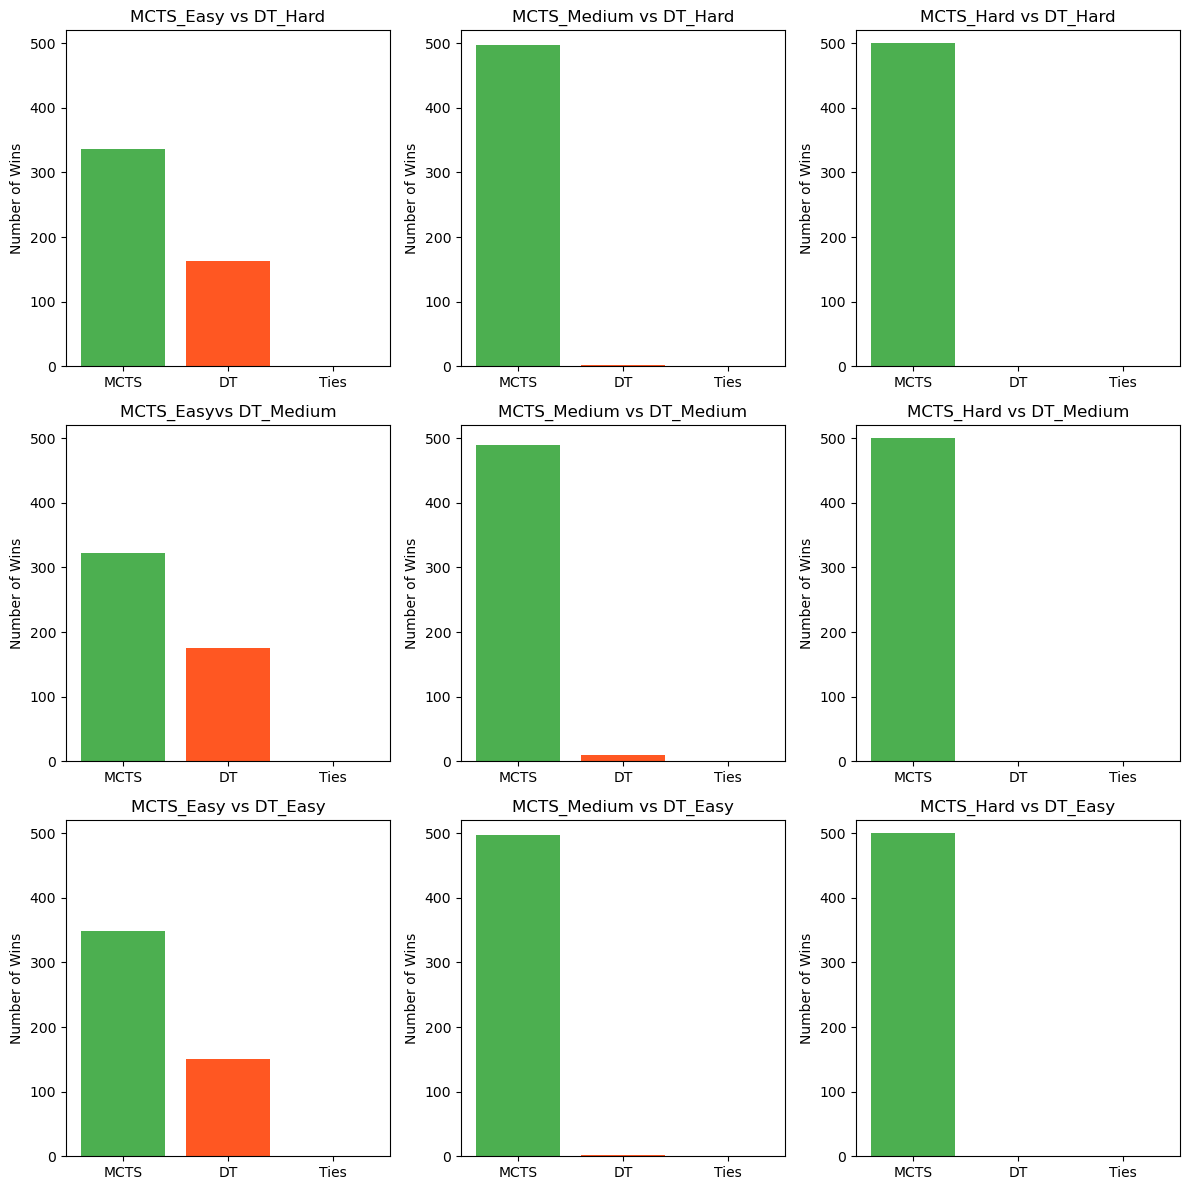

In [4]:
# Data for the matches
difficulty_levels = ['Easy', 'Medium', 'Hard']

# Results of MCTS vs DT for each difficulty (MCTS wins, DT wins, Ties)
results = {
    'MCTS_Easy vs DT_Hard': [337, 163, 0],
    'MCTS_Medium vs DT_Hard': [498, 2, 0],
    'MCTS_Hard vs DT_Hard': [500, 0, 0],
    'MCTS_Easyvs DT_Medium': [323, 176, 1],
    'MCTS_Medium vs DT_Medium': [490, 10, 0],
    'MCTS_Hard vs DT_Medium': [500, 0, 0],
    'MCTS_Easy vs DT_Easy': [349, 151, 0],
    'MCTS_Medium vs DT_Easy': [498, 2, 0],
    'MCTS_Hard vs DT_Easy': [500, 0, 0]
}

# Labels and colors for the bars
labels = ['MCTS', 'DT', 'Ties']
colors = ['#4CAF50', '#FF5722', '#FFC107']

# Create a plot for each match-up
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, (key, value) in enumerate(results.items()):
    ax = axes[i // 3, i % 3]
    ax.bar(labels, value, color=colors)
    ax.set_title(key)
    ax.set_ylabel('Number of Wins')
    ax.set_ylim(0, 520)
    
plt.tight_layout()
plt.show()


### **Key Observations**
**- Performance of MCTS vs. DT Across Levels:**

MCTS consistently outperformed DT across all difficulty levels.

MCTS_Hard achieved a perfect score of 500 wins in all matchups, regardless of the DT difficulty level.

**- Impact of Difficulty Levels:**

The higher difficulty level of MCTS showed a significant improvement in performance, leading to domination in all matchups.

DT performance decreased sharply as the MCTS difficulty increased.

**- MCTS_Easy vs. DT Performance:**

MCTS_Easy still managed to outperform DT at all difficulty levels but showed less dominance compared to its Medium and Hard counterparts.

DT performed best against MCTS_Easy, especially at DT_Medium and DT_Hard levels.

**- Lack of Ties:**

Ties were extremely rare, occurring only once in 4,500 games (MCTS_Easy vs. DT_Medium).

This suggests that the algorithms' decision-making strategies rarely led to draws, emphasizing competitive gameplay.

### **Analysis**
**- Strength of MCTS:**

The dominance of MCTS across all difficulty levels highlights its strength as an algorithm for Connect 4. The iterative simulations and probabilistic evaluations in MCTS likely provided a significant advantage over the rule-based decision-making of DT.

**- Limitations of DT:**

The DT algorithm struggled particularly at higher MCTS difficulties, potentially due to the lack of flexibility and adaptability in its approach.

The static nature of decision trees makes them less suited for dynamic and strategic games like Connect 4.

**- Difficulty Scaling:**

The results demonstrate that MCTS benefits greatly from increased computational depth and sophistication, while DT's performance improvement with difficulty scaling was marginal.

**Link for the video summary:** https://youtu.be/cHLBb0yyS18